In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image


import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time
from utils.model_utils import *
from utils.plot_utils import *
from utils.trainer import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((64,64))])
dataset = ImageFolder("./data/",transform)

train_dataset,test_dataset = random_split(dataset,[round(0.7 * len(dataset)), round(0.3 * len(dataset))])

In [5]:
BATCH_SIZE = 16
SHUFFLE = True
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


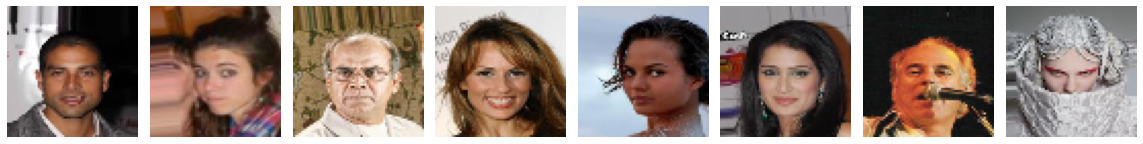

In [6]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # data = std * data + mean
    data = np.clip(data, 0, 1)

    plt.figure(figsize=(8*2, 4*2))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


imgs, _ = next(iter(train_loader))
show_grid(imgs)


In [7]:
class ResNetBlock(nn.Module):
    def __init__(self,downsample=False,in_channels=3,out_channels=64):
        super().__init__()

        self.downsample_bool = downsample
        
        
        if self.downsample_bool:

            self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, bias=False),
                                            nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        else:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

           


    def forward(self,x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out,inplace=True)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample_bool:
            identity = self.downsample(identity)
        
        out += identity
        out = F.relu(out)
        return out

        

                

In [8]:
class ResNetUpBlock(nn.Module):
    def __init__(self,upsample=False,in_channels=3,out_channels=64):
        super().__init__()

        self.upsample_bool = upsample
       

        if upsample:

            self.conv1 = nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.upconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2, bias=False)
            self.upbn = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        else:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


           


    def forward(self,x):
        identity = x
        if self.upsample_bool:
            out = self.conv1(x, output_size=(x.shape[2]*2, x.shape[2]*2))
            out = self.bn1(out)
            
            out = F.relu(out,inplace=True)
        else:
            out = self.conv1(x)
            out = self.bn1(out)
            out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample_bool:
            identity = self.upconv(identity, output_size=(x.shape[2]*2, x.shape[2]*2))
            identity = self.upbn(identity)
        
        out += identity
        out = F.relu(out)
        return out

In [22]:
class ResNetVAE(nn.Module):

    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self,in_channels=3,zdim=256):
        """ Model initlaizer """
        
        super().__init__()
        out_features = 512 * 2 * 2 

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=7,stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(in_features=out_features,out_features=zdim)
        self.fc_sigma = nn.Linear(in_features=out_features, out_features=zdim)
        self.fc  = nn.Linear(in_features=zdim,out_features=out_features)
        self.decoder_top = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2,padding=1)
        self.bn_decoder = nn.BatchNorm2d(num_features=3)
        self.last = nn.Sequential(nn.Conv2d(3,3,3,1,1),nn.BatchNorm2d(3),nn.Tanh())

    
    def _make_encoder(self):

        resblock1 = ResNetBlock(False,64,64)
        resdownsample1 = ResNetBlock(True,64,128)
        resdownsample2 = ResNetBlock(True, 128, 256)
        resblock3 = ResNetBlock(False, 256, 256)
        resdownsample3 = ResNetBlock(True, 256, 512)
        resblock4 = ResNetBlock(False, 512, 512)

        encoder = nn.Sequential(resblock1,resdownsample1,resdownsample2,resblock3,resdownsample3,resblock4,nn.Flatten())

        return encoder

    def _make_decoder(self):
        

        resdeconv1 = ResNetUpBlock(False,512,512)
        resupsample1 = ResNetUpBlock(True,512,256)
        resupsample2 = ResNetUpBlock(True, 256, 128)
        resdeconv3 = ResNetUpBlock(False, 128, 128)
        resupsample3 = ResNetUpBlock(True, 128, 64)
        resupsample4 = ResNetUpBlock(True, 64, 32)
        resdeconv5 = ResNetUpBlock(False, 32, 32)
        
       

        decoder = nn.Sequential(resdeconv1,resupsample1,resupsample2,resdeconv3,resupsample3,resupsample4,resdeconv5) 
        
        
        
        return decoder

        
    def encode(self,x):
        x_in = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x_enc = self.encoder(x_in)

        return x_enc
    
    def decode(self,z):
        z_in = F.relu(self.fc(z))
        z_in = z_in.view(-1,512,2,2)
        # decoding
        x_hat = self.decoder(z_in)
        x_hat = F.relu(self.bn_decoder(self.decoder_top(x_hat,output_size = (64,64))))
        x_hat = self.last(x_hat)

        return x_hat
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
       
       
        x_enc = self.encode(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
       
        return x_hat, (z, mu, log_var)


In [23]:
resvae = ResNetVAE()
resvae.to(device)

ResNetVAE(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

In [24]:
def vae_loss_function(recons, target, mu, log_var, lambda_recons=1, lambda_elbo=1):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target, reduction="sum")
    b_size = recons.shape[0]
#     recons_loss = F.binary_cross_entropy(recons.view(b_size,-1), target.view(b_size,-1), reduction='sum')
    elbo = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (lambda_recons * recons_loss + lambda_elbo * elbo) / b_size, (recons_loss, elbo)


In [25]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """

    loss_list = []
    recons_loss = []
    vae_loss = []

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        progress_bar.set_description(
            f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

    mean_loss = np.mean(loss_list)

    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath=""):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    vae_loss = []

    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)

        # Forward pass
        recons, (z, mu, log_var) = model(images)

        loss, (mse, kld) = criterion(recons, images, mu, log_var)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())

        if(i == 0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(
                savepath, f"recons{epoch}.png"))

    # Total correct predictions and loss
    loss = np.mean(loss_list)

    return loss


In [26]:
def train_model(model, optimizer, scheduler, criterion, train_loader,
                valid_loader, num_epochs, savepath, save_frequency=5):
    """ Training a model for a given number of epochs"""

    train_loss = []
    val_loss = []
    loss_iters = []

    for epoch in range(num_epochs):

        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % 5 == 0 or epoch == num_epochs - 1)
        loss = eval_model(
            model=model, eval_loader=valid_loader, criterion=criterion,
            device=device, epoch=epoch, savefig=log_epoch, savepath=savepath
        )
        val_loss.append(loss)

        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer,
            criterion=criterion, epoch=epoch, device=device
        )

        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters

        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters,
                "name": "res_vae"
            }
            save_model(model=model, optimizer=optimizer,
                       epoch=epoch, stats=stats, name="res_vae")

        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")

    print(f"Training completed")
    return train_loss, val_loss, loss_iters


In [27]:
savepath = "imgs/res_vae/"
optimizer = torch.optim.Adam(resvae.parameters(), lr=3e-4)

In [12]:
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, factor=0.1, verbose=True)

train_loss, val_loss, loss_iters = train_model(
    model=resvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
    train_loader=train_loader, valid_loader=test_loader, num_epochs=30, savepath=savepath
)

Epoch 1 Iter 8864: loss 376.89618. : 100%|██████████| 8864/8864 [04:02<00:00, 36.49it/s]


    Train loss: 576.82153
    Valid loss: 2803.01338


Epoch 6 Iter 8864: loss 301.92227. : 100%|██████████| 8864/8864 [04:04<00:00, 36.30it/s]


    Train loss: 259.38943
    Valid loss: 258.5044


Epoch 11 Iter 8864: loss 249.69617. : 100%|██████████| 8864/8864 [04:07<00:00, 35.76it/s]


    Train loss: 237.96933
    Valid loss: 235.32037


Epoch 16 Iter 8864: loss 218.24236. : 100%|██████████| 8864/8864 [04:17<00:00, 34.36it/s]


    Train loss: 229.70764
    Valid loss: 226.32883


Epoch 21 Iter 8864: loss 215.75302. : 100%|██████████| 8864/8864 [04:19<00:00, 34.12it/s]


    Train loss: 224.47921
    Valid loss: 222.83298


Epoch 26 Iter 8864: loss 211.74622. : 100%|██████████| 8864/8864 [04:03<00:00, 36.39it/s]


    Train loss: 220.80655
    Valid loss: 219.32943


Epoch 30 Iter 8864: loss 205.31654. : 100%|██████████| 8864/8864 [04:00<00:00, 36.87it/s]

    Train loss: 218.26982
    Valid loss: 217.43515
Training completed


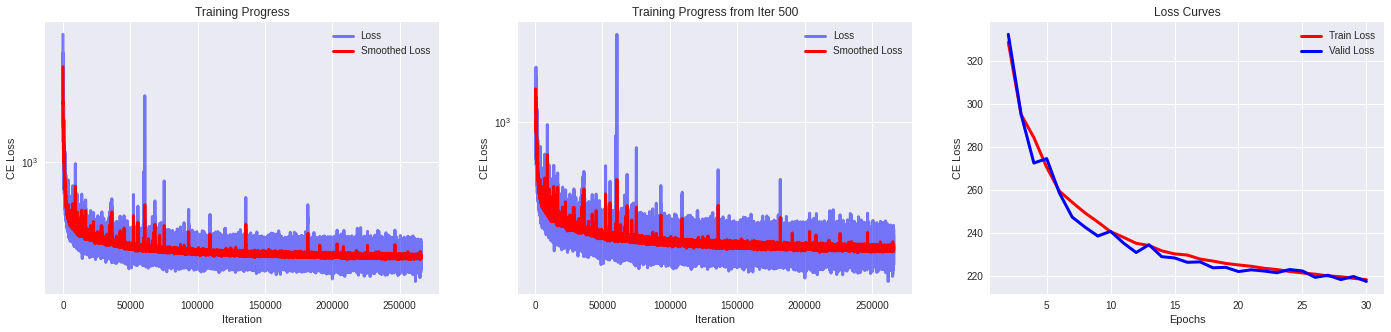

In [13]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_yscale("log")
ax[0].set_title("Training Progress")

smooth_loss = smooth(loss_iters, 31)
START = 500
N_ITERS = len(loss_iters)
ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:],
           c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:],
           c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title(f"Training Progress from Iter {START}")

epochs = np.arange(len(train_loss)) + 1
ax[2].plot(epochs[1:], train_loss[1:], c="red",
           label="Train Loss", linewidth=3)
ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("CE Loss")
ax[2].set_title("Loss Curves")


plt.show()


In [28]:
model, optimizer = load_model(model=resvae, optimizer=optimizer, savepath=os.path.join(
    "models", "res_vae", "checkpoint_epoch_25.pth"), plot=False)


In [29]:
def add_noise(img, mean=0, sigma=0.3):
    """ Adding AWGN to images"""
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma)
    return noisy_img.clamp(0,1)

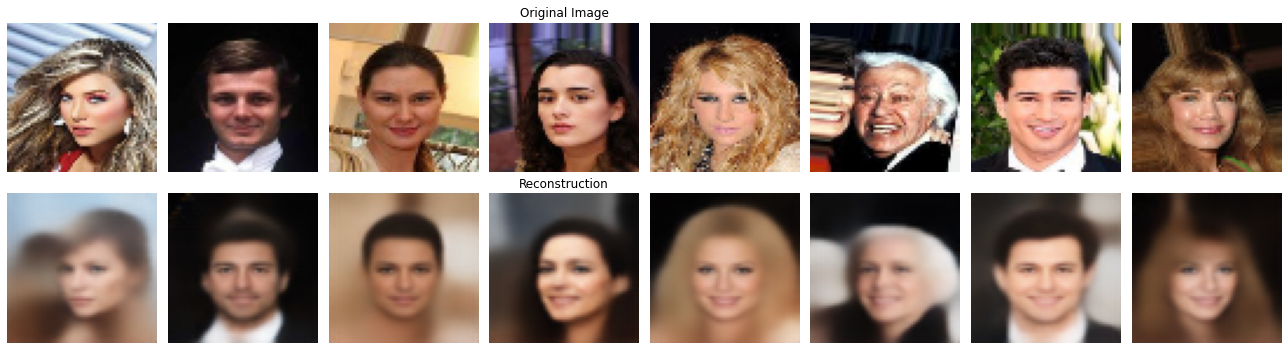

In [30]:
imgs, _ = next(iter(test_loader))

model.eval()
with torch.no_grad():
    recons, _ = model(imgs.to(device))

fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):

    ax[0, i].imshow(imgs[i].permute((1, 2, 0)))
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i].permute((1, 2, 0)).cpu())
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()


In [41]:
@torch.no_grad()
def linear_interpolate():
    imgs, _ = next(iter(test_loader))
    
    img1 = imgs[0].to(device).unsqueeze(0)
    img2 = imgs[1].to(device).unsqueeze(0)
    _, (z1, _, _) = model(img1)
    _, (z2, _, _) = model(img2)

    factors = np.linspace(1, 0, num=10)
    result = []

    with torch.no_grad():

        for f in factors:
            z = (f * z1 + (1 - f) * z2).to(device)
            im = torch.squeeze(model.decode(z).cpu())
            result.append(im)
    return result



In [47]:
result1 = linear_interpolate()
result2 = linear_interpolate()
result3 = linear_interpolate()
result4 = linear_interpolate()
result5 = linear_interpolate()



torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


In [48]:
save_image(result1+result2+result3+result4+result5,"/home/dhagash/MS-GE-03/CudaVision/assignment-6/imgs/res_vae/interpolate.png",padding=0,nrow=10)

![](interpolate.png)